<a href="https://colab.research.google.com/github/Nikhild1093/Nikhild1093/blob/main/Big_Mart_Sales_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brijbhushannanda1979/bigmart-sales-data")

print("Path to dataset files:", path)

100%|██████████| 307k/307k [00:00<00:00, 29.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/brijbhushannanda1979/bigmart-sales-data/versions/1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [3]:
test  = pd.read_csv('/root/.cache/kagglehub/datasets/brijbhushannanda1979/bigmart-sales-data/versions/1/Test.csv')
train = pd.read_csv('/root/.cache/kagglehub/datasets/brijbhushannanda1979/bigmart-sales-data/versions/1/Train.csv')

In [4]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [13]:
#Check missing values
train.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


In [7]:
#Handling missing values
#Replace with Mean for item weight & Mode for outlet size since it is categorical data

train['Item_Weight'].mean()

np.float64(12.857645184135976)

In [8]:
#fill the missing values
train['Item_Weight'] = train['Item_Weight'].fillna(train['Item_Weight'].mean())

In [9]:
mode=train.pivot_table(values='Outlet_Size',columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [11]:
missing_values = train['Outlet_Size'].isnull()

In [31]:
#Replace missing values with most common outlet size for that Type
train.loc[missing_values,'Outlet_Size'] = train.loc[missing_values,'Outlet_Type'].apply(lambda x: mode.loc['Outlet_Size', x])

In [14]:
#CHeck statistical measures for some data
sns.set()

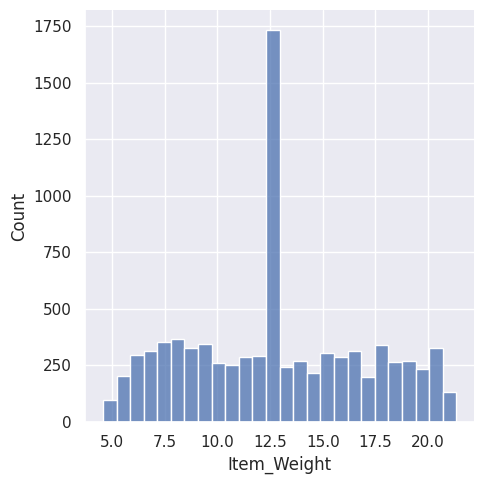

In [15]:
sns.displot(train.Item_Weight)
plt.show()

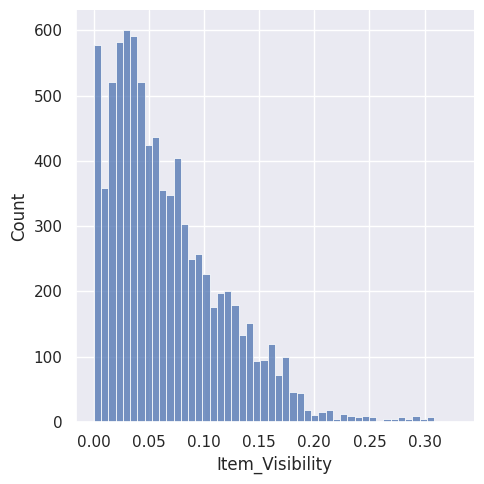

In [16]:
sns.displot(train.Item_Visibility)
plt.show()

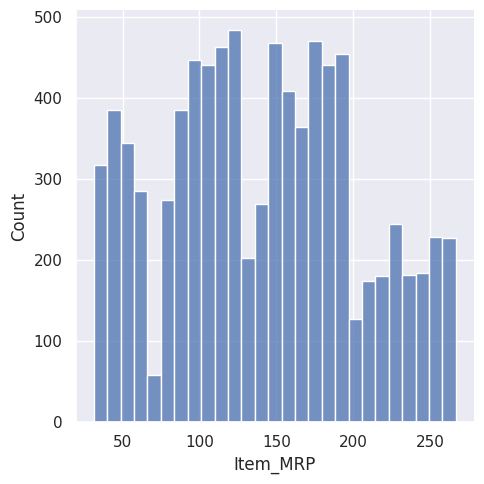

In [17]:
sns.displot(train.Item_MRP)
plt.show()

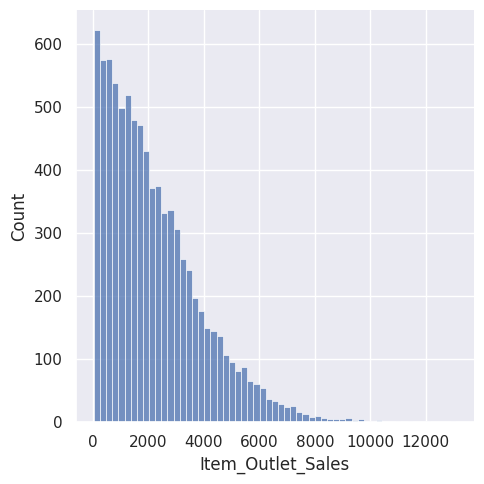

In [18]:
sns.displot(train.Item_Outlet_Sales)
plt.show()

In [22]:
outlet_counts = train['Outlet_Establishment_Year'].value_counts().sort_index()
print(outlet_counts)

Outlet_Establishment_Year
1985    1463
1987     932
1997     930
1998     555
1999     930
2002     929
2004     930
2007     926
2009     928
Name: count, dtype: int64


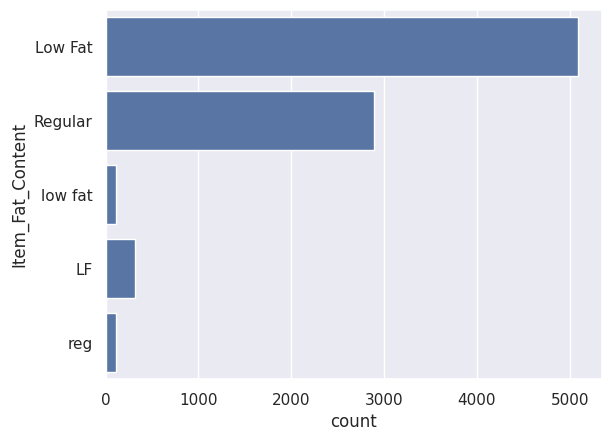

In [28]:
sns.countplot(train.Item_Fat_Content)
plt.show()

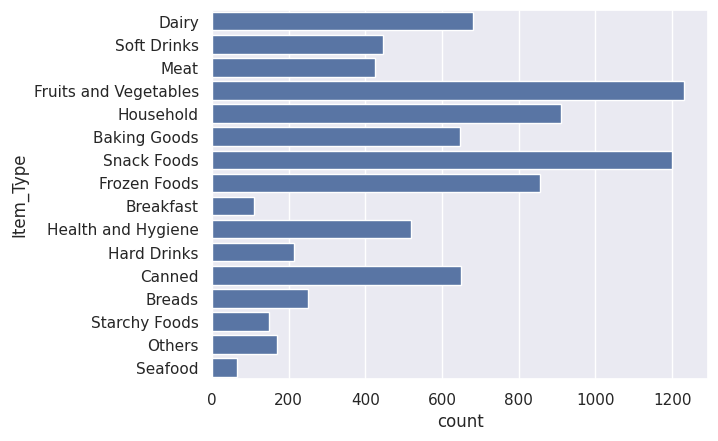

In [29]:
sns.countplot(train.Item_Type)
plt.show()

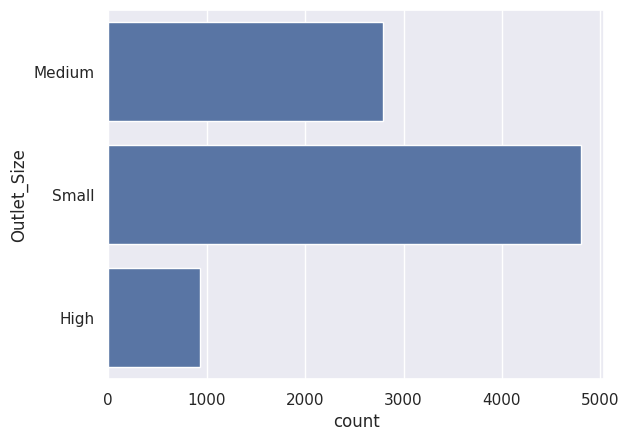

In [32]:
sns.countplot(train.Outlet_Size)
plt.show()

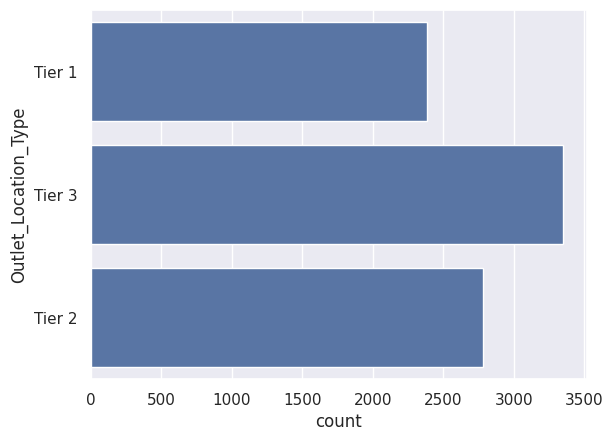

In [33]:
sns.countplot(train.Outlet_Location_Type)
plt.show()

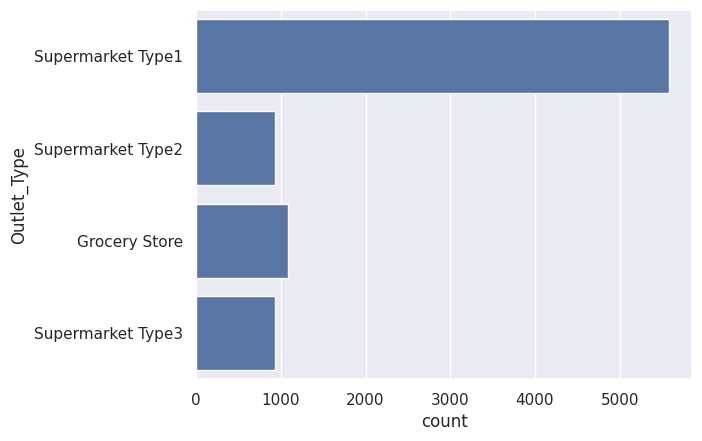

In [34]:
sns.countplot(train.Outlet_Type)
plt.show()

Label Encoding the categorical variables

In [37]:
train['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [36]:
train.replace({'Item_Fat_Content':{'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}}, inplace=True)

In [38]:
encoder = LabelEncoder()

In [39]:
train[('Item_Identifier')]      = encoder.fit_transform(train['Item_Identifier'])
train[('Item_Fat_Content')]     = encoder.fit_transform(train['Item_Fat_Content'])
train[('Item_Type')]            = encoder.fit_transform(train['Item_Type'])
train[('Outlet_Identifier')]    = encoder.fit_transform(train['Outlet_Identifier'])
train[('Outlet_Size')]          = encoder.fit_transform(train['Outlet_Size'])
train[('Outlet_Location_Type')] = encoder.fit_transform(train['Outlet_Location_Type'])
train[('Outlet_Type')]          = encoder.fit_transform(train['Outlet_Type'])

Feature Selection

In [54]:
X = train.drop(columns='Item_Outlet_Sales',axis=1)
Y = train['Item_Outlet_Sales']



In [50]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Train/test split

In [55]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1)

Model Training (XGBoost)

In [45]:
regressor = XGBRegressor()
regressor.fit(Xtrain,Ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Model Evaluation

In [57]:
#Training data accuracy
xtrPredict = regressor.predict(Xtrain)

r2_train = metrics.r2_score(xtrPredict,Ytrain)
r2_train

0.8010840910389811

In [58]:
#Test data accuracy

xtstPredict = regressor.predict(Xtest)

r2_train = metrics.r2_score(xtstPredict,Ytest)
r2_train

0.8014779734362512